# Table of Contents
- [Imports](#Imports)
- [Plan](#Plan)
- [Building the Auburn Cut](#Auburn)
- [Kolmogorov-Smirnov Tests](#KS)
- [Mann-Whitney Tests](#MW)
- [Examining a Few Distributions](#Examining)
- [Saving the Data](#Saving)

## Imports <a id="Imports"></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from distfit import distfit
from scipy.stats import ks_2samp, mannwhitneyu

## Plan <a id="Plan"></a>

I have three "cuts" of the data that I want to perform machine learning on:

- all the usable data (i.e. excluding entries that don't have reports)

- the "Auburn" cut, which should remove Vultology reports from authors that have 20 or fewer reports (since they are less experienced)

- the "Lapis" cut, layered over the Auburn cut, which should take into account this analysis:
"I'm seeing something rather suspicious in the data. If I calculate P-axis coordinates with the formula (Suspended - Grounded )/(Suspended + Grounded ), which ranges from -1 (completely Grounded) to +1 (completely Suspended), then there are 90 samples with -1, i.e., Grounded with zero signal mixing.  However, there are only 8 samples in the (-1, -0.9] interval.  In the (-0.9, 0.8] interval there are 40 samples. IMO that strongly suggests that many of those Grounded samples with zero P-axis signal mixing have neglected Suspended signals. The other end of the spectrum also looks suspicious, though it's less extreme. 
There are 36 samples with P-axis coordinates of 1 (Suspended with zero signal mixing), only 3 samples in the [0.9, 1) interval, but 26 samples in the [0.8, 0.9) interval. As for J-axis coordinates, (Measured - Candid)/(Measured + Candid), there are 55 samples with coordinates of 1 (Measured with zero signal mixing), 23 samples in the [0.9, 1) interval, and 35 in the [0.8, 0.9) interval.  There's still an odd dip, but it's a lot less suspicious. At the other end, there are 23 samples with -1 (Candid with zero signal mixing), 12 samples in the (-1, -0.9] interval and 18 samples in the (-0.9, -0.8] interval. It might be worth repeating the statistical analysis reported earlier in this channel just on samples in the (-0.9, 0.9) intervals."

We will see if these different versions of the data give different statistical results or different results in machine learning algorithms.

For now the focus is on the Auburn cut of the data. There are a lot of things to statistically investigate in each of these versions of the data, and I don't want to waste time and energy. Thus, I'm going to statistically compare all of the usable data to the Auburn cut to see if there is an statistically significant difference in the distribution of each column. I'll only bother to investigate a column if there is a statistically significant difference in the distribution as a result of applying the cut.

First we need to build the Auburn Cut so we can make the comparisons, and to do that we'll need to look at the value counts for the Vultologist column to see which Vultologists will have their samples included in this cut

## Building the Auburn Cut <a id="Auburn"></a>

In [2]:
all_df = pd.read_csv('../Data/posts_2024-12-29_CleanData.csv', index_col=0)
all_df.reset_index(drop=True, inplace=True)
all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672 entries, 0 to 671
Data columns (total 87 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Sample Name                    672 non-null    object 
 1   Vultologist                    672 non-null    object 
 2   Type                           672 non-null    object 
 3   Development                    672 non-null    object 
 4   Emotions                       672 non-null    object 
 5   Fallen Affect                  672 non-null    float64
 6   Sex                            672 non-null    object 
 7   Age Range                      672 non-null    object 
 8   Geography                      672 non-null    object 
 9   Ethnicity                      672 non-null    object 
 10  R1 Rigid Posture               672 non-null    float64
 11  R2 Face Centric                672 non-null    float64
 12  R3 Punctuated Motions          672 non-null    flo

In [3]:
all_df['Vultologist'].value_counts()

Vultologist
Calin Copil          290
Juan E. Sandoval     169
Peter Foy             79
Sierra Schwartz       37
Ash Rose              30
Hila Hershkoviz       15
Jacquelyn Scott       14
Ahmad Aldroubi        10
Nathaniel Vetter      10
Victoria G             4
Miriam Greenfield      4
Mitchell Newman        4
Robert Geary           3
Bryson L.              1
jordan                 1
Kyle O’Reilly          1
Name: count, dtype: int64

It looks like the only Vultologists I'll be including in this cut are Calin, Auburn, Peter, Sierra and Ash

In [4]:
auburn_df = all_df[all_df['Vultologist'].isin(['Calin Copil', 'Juan E. Sandoval', 'Peter Foy', 'Sierra Schwartz', 'Ash Rose'])]
auburn_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 605 entries, 0 to 671
Data columns (total 87 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Sample Name                    605 non-null    object 
 1   Vultologist                    605 non-null    object 
 2   Type                           605 non-null    object 
 3   Development                    605 non-null    object 
 4   Emotions                       605 non-null    object 
 5   Fallen Affect                  605 non-null    float64
 6   Sex                            605 non-null    object 
 7   Age Range                      605 non-null    object 
 8   Geography                      605 non-null    object 
 9   Ethnicity                      605 non-null    object 
 10  R1 Rigid Posture               605 non-null    float64
 11  R2 Face Centric                605 non-null    float64
 12  R3 Punctuated Motions          605 non-null    float64


We have only removed 67 samples, so I'm thinking this won't necessarily be statistically significant changes for most of the distributions, though you never know since we specifically removed reports from relatively inexperienced Vultologists who may have exerted a disporportionate influence due to relatively unorthodox practices (but I suspect not in most cases)

Next we can use the Kolmogorov-Smirnov test and the Mann-Whitney test to see if there are any statistically differences between the Auburn cut and the Full Data. The reason to use two separate tests is that they work better in different domains:
- the KS test works best in the case where we want to compare the shapes of most complex continuous distributions
- the MW test works best when we want to compare relatively discrete values (such as the signals have) since the KS test doesn't work well with discrete, categorical distributions since it doesn't work with a lot of "ties"

## Kolmogorov-Smirnov Tests <a id="KS"></a>

The distributions we can examine with this test are the most complex relatively continuous distributions such as:
- sum of signals
- Emotion value distributions
- Signal mixing distributions

In [5]:
KS_cols = ['sum', 'Emotion_Val', 'Emotion_RawDiff', 'J_Signal_Mixing', 'P_Signal_Mixing']

KS_results = {}

for col in KS_cols:
    stat, p_value = ks_2samp(all_df[col], auburn_df[col])
    KS_results[col] = {'statistic': stat, 'p_value': p_value}

KS_df = pd.DataFrame.from_dict(KS_results)
KS_df.transpose()

,statistic,p_value
sum,0.019089,0.999650
Emotion_Val,0.023224,0.993336
Emotion_RawDiff,0.019407,0.999531
J_Signal_Mixing,0.010791,1.000000
P_Signal_Mixing,0.011369,1.000000


As we can see, the distributions are nearly identical for all of these and we cannot reject the null hypothesis, so we don't need to bother investigating these columns!

## Mann-Whitney Tests <a id="MW"></a>

In this case we are going to look at nearly every other column, since they are all either categorical in nature or consist of signals with mainly discrete values and thus a lot of ties that make the KS test ineffective

In [6]:
MW_cols = [col for col in list(auburn_df.columns) if (col not in KS_cols) and (col not in ['Sample Name', 'Vultologist'])]

MW_results = {}

for col in MW_cols:
    if all_df[col].dtype == 'O':
        stat, p_value = mannwhitneyu(all_df[col].value_counts(), auburn_df[col].value_counts())
    else:
        stat, p_value = mannwhitneyu(all_df[col], auburn_df[col])
    MW_results[col] = {'statistic': stat, 'p_value': p_value}

MW_df = pd.DataFrame.from_dict(MW_results)
with pd.option_context("display.max_rows", 1000):
    print(MW_df.transpose().sort_values('p_value'))

                               statistic   p_value
EG3 Stern Expressions           195077.0  0.191685
EG2 Assertive Pushing           197252.5  0.324398
Type                               152.5  0.365140
MS4 Symmetrical Lips            208444.5  0.414388
MS8 Laryngeal Faint Voice       198664.0  0.459866
Quadra                              11.0  0.485714
RR2 Disengaging Eyes            207680.0  0.487526
MS9 Puppeteer Hands             207154.0  0.510304
Fallen Affect                   199309.5  0.515817
Development                         38.5  0.528309
CA3 Four Point Pulling          199738.0  0.575234
F4 Horizontal Movements         199773.0  0.577368
SU3 Lax Outer Edges             206593.5  0.584503
CA1 Taut Nasolabial Area        199961.0  0.599926
CA9 Grasping Hands              206104.5  0.608598
SU5 Brushstrokes Eye Toggles    206385.5  0.615567
RF4 Searching Scowling          200348.5  0.636884
RR3 Exerted Pushes              206145.0  0.640531
SU6 Eye Head Trailing Motions  

There isn't a notably statistically significant difference for all of these columns either (even for a relaxed p-value cutoff points like 10%). Since p-value cutoff points are technically arbitrary, I think it's still worth examining some of the lower p-values on these lists. However, since something like "type" ends up with a pretty low p-value, and I doubt the distribution of type is all that different in the auburn_cut, I don't think much of any of this is going to be significant

## Examining a Few Distributions <a id="Examining"></a>

### Stern Expressions

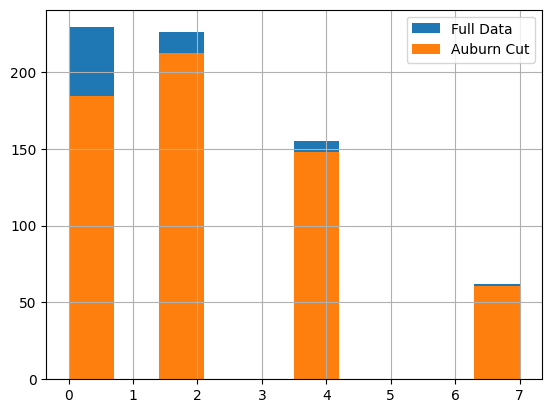

In [7]:
fig, ax = plt.subplots()

all_df['EG3 Stern Expressions'].hist(label='Full Data')
auburn_df['EG3 Stern Expressions'].hist(label='Auburn Cut')
ax.legend();

It's interesting that we are losing a lot of cases from the Full Data where Stern Expressions wasn't marked, meaning that Experienced Vultologists tend to mark this more (at least at a value of 2). That could be significant for clustering EA signals

### Assertive Pushing

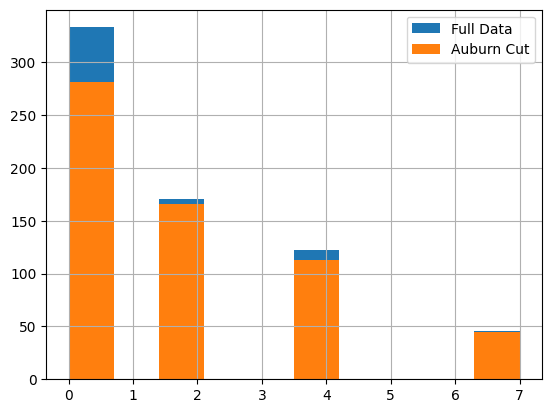

In [8]:
fig, ax = plt.subplots()

all_df['EG2 Assertive Pushing'].hist(label='Full Data')
auburn_df['EG2 Assertive Pushing'].hist(label='Auburn Cut')
ax.legend();

Yet again we are losing a lot of cases where Assertive Pushing wasn't marked, just to a less extreme degree.

### Type

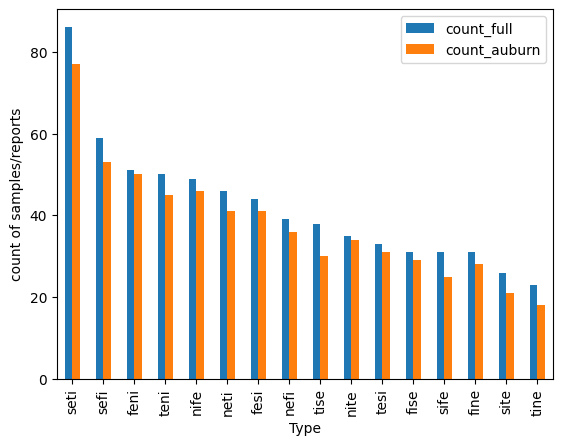

In [9]:
type_join = all_df['Type'].value_counts().to_frame().join(auburn_df['Type'].value_counts().to_frame(), lsuffix='_full', rsuffix='_auburn')
type_join.plot(use_index=True, y=['count_full', 'count_auburn'], kind='bar')
plt.ylabel("count of samples/reports");

On the whole the distribution here is quite similar, there are just larger losses for some types than others. I'm not sure it's significant because there doesn't seem to be much pattern in the greater losses. There are a lot of lost SeTi for example (which is even sort of strange because Calin is himself SeTi and he adds a lot of reports, so you'd think he would add more SeTi yet they were disproportionately lowered by excluding inexperienced vultologists), but it's still by far the most common. Then there's a large jump of losses, such that it upsets the rank of the rank of the type in the distribution, for TeNi, NeTi, TiSe, and SiFe. Since there isn't much pattern here, I can't imagine it will have a significant affect on our clustering and other statistical investigations (especially compared to the benefit of having more samples in the full data).

### Symmetrical Lips

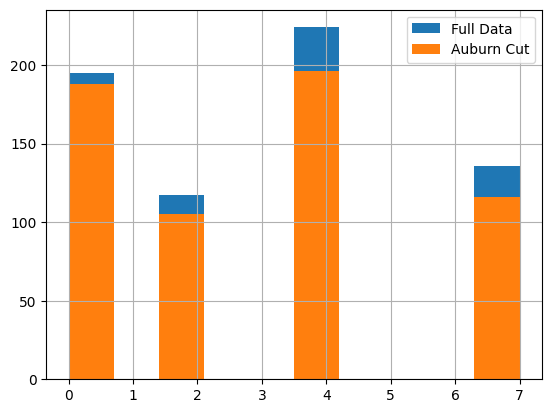

In [10]:
fig, ax = plt.subplots()

all_df['MS4 Symmetrical Lips'].hist(label='Full Data')
auburn_df['MS4 Symmetrical Lips'].hist(label='Auburn Cut')
ax.legend();

In this case, it's the opposite of the Guarded signals where the inexperienced vultologists are marking symmetrical lips more frequently. This might be noteworthy but it contradicts the previous pattern which is odd.

### Laryngeal Faint Voice

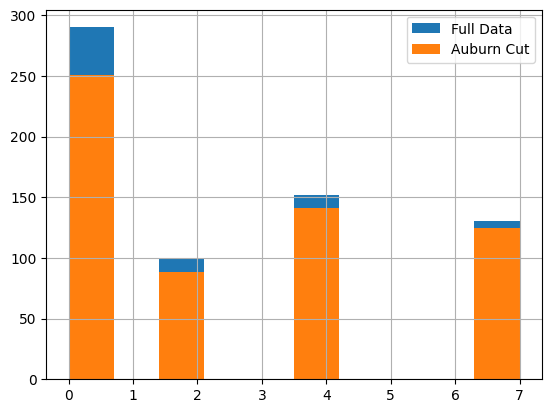

In [11]:
fig, ax = plt.subplots()

all_df['MS8 Laryngeal Faint Voice'].hist(label='Full Data')
auburn_df['MS8 Laryngeal Faint Voice'].hist(label='Auburn Cut')
ax.legend();

And this signal is marked less again (just to a lesser degree than the previous guarded signals with more conspicuous p-values)

### Quadra

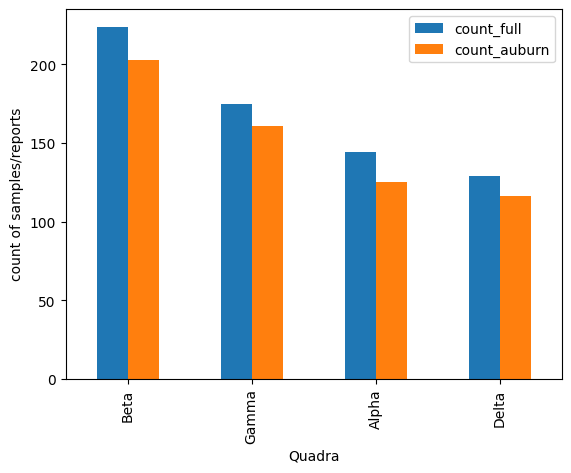

In [12]:
quadra_join = all_df['Quadra'].value_counts().to_frame().join(auburn_df['Quadra'].value_counts().to_frame(), lsuffix='_full', rsuffix='_auburn')
quadra_join.plot(use_index=True, y=['count_full', 'count_auburn'], kind='bar')
plt.ylabel("count of samples/reports");

Here it's hard to even see much difference or unevenness; may we lose more measured samples in general? But you have to squint to see it.

At this point, I don't think we need to look at the particularities of these distributions anymore. We can save the Auburn cut of the data, keeping in mind some of these patterns we found, and if the Auburn cut gets notably different results in other investigations (like clustering or other statistical tests), we can dig deeper into the cause if it isn't already obvious

## Saving the Data <a id="Saving"></a>

In [13]:
auburn_df.to_csv('../Data/posts_2024-12-29_AuburnCut.csv')